**рекуррентная нейронная сеть Элмана**

Евгений Борисов <esborisov@sevsu.ru>


построим простую языковая модель и
обучим её предсказывать последнюю букву в слове


----

Евгений Борисов  О рекуррентных нейронных сетях.    
http://mechanoid.su/neural-net-rnn.html

Jeffrey L. Elman Finding Structure in Time // COGNITIVE SCIENCE 14, 179-211 (1990)

---

In [1]:
# загружаем тексты
import gzip
import requests
from bs4 import BeautifulSoup

In [2]:
url='http://az.lib.ru/d/dostoewskij_f_m/text_0080.shtml'
text = BeautifulSoup(requests.get(url).text).get_text()
with gzip.open('dostoewskij.txt.gz','wt') as f: f.write(text)

# with gzip.open('dostoewskij.txt.gz','rt') as f: text = f.read()

text = text[2876:-664184].strip() # выкидываем заголовок и хвост страницы 
print(f'символов:{len(text)}\n---------------\n'%())
print(text[:355])

символов:1279540
---------------

Приступая к описанию недавних и столь странных событий, происшедших в нашем, доселе ничем не отличавшемся городе, я принужден, по неумению моему, начать несколько издалека, а именно некоторыми биографическими подробностями о талантливом и многочтимом Степане Трофимовиче Верховенском. Пусть эти подробности послужат лишь введением к предлагаемой хронике, 


----

In [3]:
import numpy as np
from numpy import random as rng
from matplotlib import pyplot as plt

In [4]:
from random import sample
from tqdm.auto import tqdm
from itertools import chain

In [5]:
from nltk import __version__ as nltk_version
print('nltk version:',nltk_version)

from nltk.tokenize import sent_tokenize as nltk_sentence_split
from nltk.tokenize import word_tokenize as nltk_tokenize_word
from nltk.util import ngrams

nltk version: 3.8.1


In [6]:
class WordsDataset:
    
    def __init__(self,text,max_words):
        assert len(text)>1
         # выполняем токенизацию текста 
        self._words = sample([ 
                w
                for s in tqdm(nltk_sentence_split(text,language='russian')) # режем текст на отдельные предложения
                for w in nltk_tokenize_word(s,language='russian') # разбиваем предложения на слова
                if len(w)>3 # выкинем короткие слова
            ],max_words)
        
        abc = ['<pad>']+sorted(set(chain(*self._words)))
        self._vocabulary = { c:n for n,c in enumerate(abc) }
        
        self._data = self._one_hot(
                np.array(
                     self._pad_seq([ self._encode(w) for w in self._words ])
                    ,dtype=np.uint32
                )
            )
    
    @property
    def vocabulary(self): 
        return self._vocabulary
    
    @property
    def words(self): return self._words
     
    # заменить в последовательности все токены на их номера в словаре
    def _encode(self,w):
        return [ self._vocabulary[c] for c in w if (c in self._vocabulary) ]
        
    def __getitem__(self, idx): # выдать элемент датасета номер idx
        return ( self._data[idx,:-1],  self._data[idx,-1] )
        
    def _pad_seq(self,s):
        max_len = max([ len(w) for w in s])
        pad = self._vocabulary['<pad>']
        return [ [pad]*(max_len-len(w))+w for w in s ]
    
    def _one_hot(self,x):
        return np.eye( len(self._vocabulary), dtype=np.float32 )[x]

    # размер датасета
    def __len__(self): 
        return len(self._data)        

In [7]:
ds = WordsDataset(text,32)
display(len(ds) )
display(len(ds.vocabulary))
# display(ds.words)

  0%|          | 0/14424 [00:00<?, ?it/s]

32

34

In [8]:
x,t = ds[:2]
display((x.shape,t.shape))

((2, 12, 34), (2, 34))

In [9]:
display(ds.words)

['выражение',
 'Надо',
 'было',
 'сударыня',
 'своего',
 'устала',
 'дикая',
 'глаза',
 'Итак',
 'жизнь',
 'доволен',
 'невероятными',
 'Степана',
 'жить',
 'значения',
 'полевая',
 'глядели',
 'деле',
 'бешенство',
 'успешно',
 'Лиза',
 'Марье',
 'знавший',
 'почему',
 'которую',
 'Кажется',
 'графа',
 'ругательством',
 'поправил',
 'ожидаемой',
 'себя',
 'лакейскую']

# строим модель

In [10]:
from numpy import random as rng

In [11]:
class Sigmoid: # функция активации
    
    def forward(self,x): 
        return np.tanh(x)

    def backward(self,x): # производная активации
        return 1./(np.cosh(x)**2)
    
    def __call__(self,x):
        return self.forward(x)

Text(0.5, 1.0, 'd sigmoid')

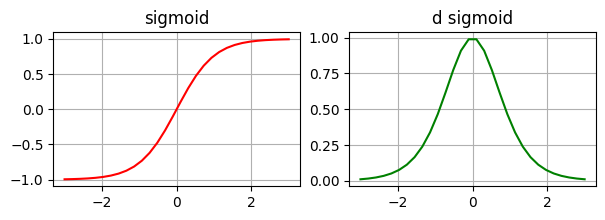

In [12]:
f = Sigmoid()
x = np.linspace(-3,3,30)
fig,ax = plt.subplots(ncols=2,figsize=(7,2))
ax[0].plot(x,f(x),'-r')
ax[0].grid()
ax[0].set_title('sigmoid' )
ax[1].plot(x,f.backward(x),'-g')
ax[1].grid()
ax[1].set_title('d sigmoid' )

In [13]:
class Linear:
    
    def __init__(self,in_size,out_size):
        self._weight = rng.normal(loc=0.,scale=1e-5,size=(in_size,out_size))
        self._bias = np.zeros(shape=(1,out_size))
        
    def forward(self,x):
        assert len(x)>0
        assert x.shape[-1]==self._weight.shape[0]
        return x.dot(self._weight)+self._bias

    def forward_train(self,x):
        return self.forward(x)
    
    def backward(self,d):
        return d.dot(self._weight.T)
    
    def gradient(self,x,d):
        return x.T.dot(d), d.sum(axis=0,keepdims=True) 
    
    def __call__(self,x):
        return self.forward(x)
    
    @property
    def weight(self):
        return self._weight, self._bias

    @weight.setter
    def weight(self,w):
        self._weight=w[0] 
        self._bias=w[1]
        return self

In [14]:
# in_size,out_size = 7,5

# model = Linear(in_size,out_size)
# x = rng.rand(2,in_size)
# t = rng.rand(2,out_size)

# display(x.shape)

# o = model(x)
# display(o.shape)

# o = model.forward_train(x)
# display(o.shape)

# d = model.backward(t-o)
# display(d.shape)

# dw,db = model.gradient(x,t)
# display((dw.shape,db.shape))

In [15]:
class RNN:
    
    def __init__(self,in_size,hidden_size):
        self._weight_in = rng.normal(loc=0.,scale=1e-5,size=(in_size,hidden_size))
        self._weight_hidden = rng.normal(loc=0.,scale=1e-5,size=(hidden_size,hidden_size))
        self._bias = np.zeros(shape=(1,hidden_size))
        self._hidden = np.zeros(shape=(1,hidden_size)) # np.array(0.)
        self._activation = Sigmoid()
        
    def forward(self,x,h=None):
        assert len(x)>0
        assert x.shape[-1]==self._weight_in.shape[0]
        n_samples, seq_len, emb_size = x.shape
        
        _,hidden_size = self._hidden.shape
        self._hidden = h if not (h is None) else np.zeros(shape=(1,hidden_size))
        for i in range(seq_len): 
            o = self._activation(self._forward_step(x[:,i,:]))
        return self._hidden, o
    
    def _forward_step(self,x):
        assert len(x)>0
        assert x.shape[-1]==self._weight_in.shape[0]
        self._hidden = x.dot(self._weight_in) + self._hidden.dot(self._weight_hidden) + self._bias
        return self._hidden
        
    def forward_train(self,x,h=None):
        assert len(x)>0
        assert x.shape[-1]==self._weight_in.shape[0]
        n_samples, seq_len, _ = x.shape
        hidden,out = [],[]
        
        _,hidden_size = self._hidden.shape
        self._hidden = h if not (h is None) else np.zeros(shape=(1,hidden_size))
        for i in range(seq_len): 
            hidden.append( self._forward_step(x[:,i,:]) )
            out.append( self._activation( hidden[-1] ) )
        return hidden, out
    
    def backward(self,d,state):
        seq_len = len(state)
        delta = [d]
        for s in state[::-1]:
            delta.append( delta[-1].dot(self._weight_hidden.T)*self._activation.backward(s) )
        return delta[::-1]
    
    def gradient(self,x,out,delta):
        batch_size,seq_len,_ = x.shape
        dw,dwr,db = 0.,0.,0.
        for i in range(seq_len):
            dw  += x[:,i,:].T.dot( delta[i] )
            dwr += out[i].T.dot( delta[i] )
            db  += delta[i].sum(axis=0,keepdims=True) 
        return dw,dwr,db   
            
    def __call__(self,x):
        return self.forward(x)
    
    @property
    def weight(self):
        return self._weight_in, self._weight_hidden,  self._bias

    @weight.setter
    def weight(self,w):
        self._weight_in=w[0] 
        self._weight_hidden=w[1] 
        self._bias=w[2]
        return self
    
    @property
    def hidden(self):
        return self._hidden

In [16]:
# in_size, seq_len, out_size = 7,9,5

# model = RNN(in_size,out_size)
# x = rng.rand(2,seq_len,in_size)
# d = rng.rand(2,out_size)

# display(x.shape)

# h,o = model.forward(x)
# display((h.shape,o.shape))

# h,o = model.forward_train(x)
# display( (len(h),len(o)) )

# d = model.backward(d,h[:-1])
# display(len(d))

# dw,dwr,db = model.gradient(x,o,d)
# display((dw.shape, dwr.shape, db.shape))

рекуррентная сеть Элмана 

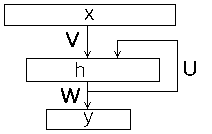

In [17]:
class ElmanRNN:
    
    def __init__(self,in_size,hidden_size,out_size):
        self._activation = Sigmoid()
        self._rnn = RNN(in_size,hidden_size)
        self._lin = Linear(hidden_size,out_size)
                
    @property
    def weight(self):
        return self._rnn.weight, self._lin.weight

    @weight.setter
    def weight(self,w):
        self._rnn.weight=w[0] 
        self._lin.weight=w[1]
        return self
    
    def forward(self,x):
        assert len(x)>0
        _,o = self._rnn(x)
        o = self._lin(o)
        o = self._activation(o)
        return o
    
    def __call__(self,x):
        return self.forward(x)
    
    def forward_train(self,x):
        state,out = [x],[]
        
        h,o = self._rnn.forward_train(x)
        state.append(h)
        out.append(o)
        
        s = self._lin.forward_train(o[-1])
        o = self._activation(s)
        state.append(s)
        out.append(o)
        
        return state, out
    
    def backward(self,d,state):
        delta = [ d*self._activation.backward(state[2]) ]
        delta.append( self._lin.backward( delta[-1]  ) * self._activation.backward( state[1][-1]) )
        delta.append( self._rnn.backward( delta[-1], state[-2][:-1] ) )
        return delta[::-1] 
    
    def gradient(self,x,out,delta):
        dw0,dw0r,db0 = self._rnn.gradient(x,out[0],delta[0])
        dw1,db1 = self._lin.gradient(out[0][-1],delta[2])    
        return [dw0,dw0r,db0],[dw1,db1] 


In [18]:
# x,t = ds[:2]
# display( (x.shape,t.shape) )

# model = ElmanRNN(in_size=x.shape[-1],hidden_size=16,out_size=x.shape[-1])

# o = model.forward(x)
# display(o.shape)

# s,o = model.forward_train(x)
# display( ( (len(s), s[-1].shape), ( len(o), o[1].shape,) ) )

# d = model.backward((o[-1]-t),s)
# display( ( len(d), d[-1].shape ) )

# [dw0,dw0r,db0],[dw1,db1] = model.gradient(x,o,d)
# display((dw0.shape, dw0r.shape, db0.shape))
# display((dw1.shape, db1.shape))

# обучаем модель

функция потери средняя квадратичная ошибка
$$L=MSQE(y,o)=\frac{1}{m}\sum\limits_{i=0}^m(o_i-y_i)^2$$

In [19]:
class MSQELoss:
    
    def __init__(self,model): 
        self._model = model
        self._history = []
                
    def estimate(self,x,target):
        s = self._estimate( target, self._model(x))
        self._history.append(s)
        return s
        
    def _estimate(self,target,predicted):
        return np.square(target-predicted).mean()
    
    def gradient(self,x,target):
        s,o = model.forward_train(x) # состояния и выходы всех нейронов сети
        d0 = (o[-1]-target) # ошибка выходного слоя
        d = model.backward(d0,s) # значение ошибки для всех нейронов скрытых слоёв
        return model.gradient(x,o,d) 
    
    def __call__(self,x,target):
        return self.estimate(x,target)        
    
    @property
    def model(self): 
        return self._model

----

In [20]:
# model = ElmanRNN(in_size=x.shape[-1],hidden_size=16,out_size=x.shape[-1])

# x,t = ds[:2]
# display( (x.shape,t.shape) )

# o = model(x)
# display(o.shape)

# loss = MSQELoss(model)
# display( loss.estimate(x,t) )

# обучаем

In [21]:
from tqdm.auto import tqdm

In [22]:
class TrainGD:
    
    def __init__(self,loss): 
        self._loss = loss
        
    def fit(self,x,t,n_echo=128,lr=1e-2):
        history = []
        for _ in tqdm(range(n_echo)):
            history.append( self._loss.estimate(x,t) )
            dw = self._loss.gradient(x,t)
            dw = self._weight_norm(dw)
            self._loss.model.weight = self._weight_adjust(self._loss.model.weight,dw,lr=lr)    
        return history,model 
    

    def _weight_adjust(self,w,dw,lr):
        return [ 
            [ w[l][n] - lr*dw[l][n] for n in range(len(w[l])) ]
            for l in range(len(w))
        ]
    
    @staticmethod
    def _weight_max(w):
        return max([ np.abs(w[l][n]).max() for l in range(len(w)) for n in range(len(w[l])) ])

    def _weight_norm(self,w):
        wm = self._weight_max(w)
        return [ 
            [  w[l][n]/wm  for n in range(len(w[l])) ]
            for l in range(len(w))
        ]

In [23]:
random_indices = rng.permutation(len(ds))

b = len(ds)//3
x_train,t_train = ds[random_indices[b:]]
x_test,t_test = ds[random_indices[:b]]

display( (x_train.shape,t_train.shape) )

display( (x_test.shape,t_test.shape) )

((22, 12, 34), (22, 34))

((10, 12, 34), (10, 34))

In [24]:
model = ElmanRNN(in_size=x_train.shape[-1],hidden_size=16,out_size=t_train.shape[-1])

In [25]:
loss_history, model = TrainGD(MSQELoss(model)).fit(x_train,t_train,n_echo=1024)

  0%|          | 0/1024 [00:00<?, ?it/s]

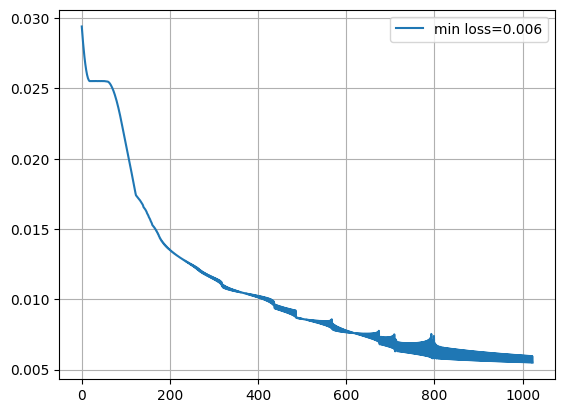

In [26]:
# история изменения значений ф-ции потери
plt.plot(loss_history,label='min loss=%.3f'%(min(loss_history)))
plt.grid()
plt.legend()

## тестируем модель

In [34]:
import pandas as pd
from sklearn.metrics import accuracy_score

In [35]:
def decode(x,vocabulary):
    v = { n:w for w,n in  vocabulary.items() }
    return [
        ''.join([ v[c] for c in s if (c!=vocabulary['<pad>']) ])
        for s in np.argmax(x,axis=-1) 
    ]

In [38]:
p = model(x_train)
display( accuracy_score(y_true=np.argmax(t_train,axis=-1), y_pred=np.argmax( p,axis=-1) ) )

0.9090909090909091

In [39]:
# декодируем слова
df = pd.DataFrame({
         'sequence': decode(x_train,ds.vocabulary),
           'target': decode(t_train[:,np.newaxis,:],ds.vocabulary),
        'predicted': decode(p[:,np.newaxis,:],ds.vocabulary)
    })

display(df)

,sequence,target,predicted
0,своег,о,о
1,был,о,о
2,лакейску,ю,ю
3,Лиз,а,а
4,Степан,а,а
5,Марь,е,е
6,глядел,и,и
7,бешенств,о,о
8,котору,ю,ю
9,невероятным,и,и


In [40]:
p = model(x_test)
display( accuracy_score(y_true=np.argmax(t_test,axis=-1), y_pred=np.argmax(p,axis=-1)) )

0.3

In [41]:
# декодируем слова
df = pd.DataFrame({
         'sequence': decode(x_test,ds.vocabulary),
           'target': decode(t_test[:,np.newaxis,:],ds.vocabulary),
        'predicted': decode(p[:,np.newaxis,:],ds.vocabulary)
    })

display(df)

,sequence,target,predicted
0,поправи,л,я
1,дика,я,я
2,Ита,к,а
3,граф,а,а
4,значени,я,й
5,глаз,а,а
6,Над,о,я
7,жит,ь,е
8,доволе,н,о
9,жизн,ь,а
